In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
from collections import defaultdict
import os
import tqdm
import gzip
import pickle

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

from fastset import FastSet

In [2]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    # numpy readcsv couldn't handle the size :(
    blocksize = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = FastSet(blocksize[bsort, 0])
bsize_values = blocksize[bsort, 1]
bsize_values = np.append(bsize_values, 0)
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index._set, s._set)].sum()

In [3]:
blockmap_filename = 'data/blockmap.pkl'
if not os.path.exists(blockmap_filename):
    blockmap_in = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,2), names=['block_id', 'dataset_id'])
    blockmap = defaultdict(FastSet)
    for bid, dsid in blockmap_in.values:
        blockmap[dsid] += FastSet([bid])

    del blockmap_in
    with gzip.open(blockmap_filename, 'wb') as fout:
        pickle.dump(blockmap, fout)
else:
    with gzip.open(blockmap_filename) as fin:
        blockmap = pickle.load(fin)

In [4]:
ws_cmssw = parquet.read_table('data/working_set_cmssw').to_pandas()
ws_cmssw['working_set_blocks'] = ws_cmssw.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [5]:
#ws_jobm = parquet.read_table('data/working_set_jmpopularity').to_pandas()
#ws_jobm['working_set_blocks'] = ws_jobm.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [6]:
ws_classads = parquet.read_table('data/working_set_classads').to_pandas()
ws_classads['working_set_blocks'] = ws_classads.apply(
    lambda x: sum((blockmap[ds] for ds in x.working_set), FastSet()), 'columns')

In [7]:
ws_xrootd = parquet.read_table('data/working_set_xrootd').to_pandas()
ws_xrootd['working_set_blocks'] = ws_xrootd.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [8]:
ws_fwjr = parquet.read_table('data/working_set_fwjr').to_pandas()
ws_fwjr['working_set_blocks'] = ws_fwjr.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [9]:
#missing_xrootd = ws_xrootd['working_set_blocks'].values.sum() - bsize_index
#print("Missing xrootd blocks:", len(missing_xrootd))
#missing_xrootd._set

In [10]:
# join the data tier definitions
titles = ['id', 'data_tier', 'day', 'user']
datatiers = pd.read_csv('data/dbs_datatiers.csv', names=titles).set_index('id')

def add_datatiers(ws):
    ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values
    
add_datatiers(ws_classads)
add_datatiers(ws_cmssw)
add_datatiers(ws_xrootd)
add_datatiers(ws_fwjr)
#add_datatiers(ws_jobm)

In [11]:
date_index = np.arange(1609459200//86400, time.time()//86400 - 1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [12]:
def calc(ws_filtered):
    blocks_day = []
    for i, day in enumerate(tqdm.tqdm(date_index, desc='Assemble block lists', unit='day')):
        today = (ws_filtered.day==day*86400)
        blocks_day.append(reduce(FastSet.union, ws_filtered[today].working_set_blocks, FastSet()))

    nrecords = np.zeros_like(date_index)
    lifetimes = {
        '1w': 7,
        '1m': 30,
        '3m': 90,
        '6m': 120,
    }
    ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
    nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
    recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
    previous = {k: FastSet() for k in lifetimes}

    for i, day in enumerate(tqdm.tqdm(date_index, desc='Simulating days', unit='day')):
        nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
        for key in lifetimes:
            current = reduce(FastSet.union, blocks_day[max(0,i-lifetimes[key]):i+1], FastSet())
            recall = current - previous[key]
            nrecalls[key][i] = len(recall)
            ws_size[key][i] = getsize(current)
            recall_size[key][i] = getsize(recall)
            previous[key] = current

    return ws_size, nrecalls, recall_size

In [13]:
def filt(ws):
    return ws[ws['data_tier'].str.match('(|MINI|NANO)AOD')]

size_cmssw, _, _ = calc(filt(ws_cmssw))
size_classads, _, _ = calc(filt(ws_classads))
size_xrootd, _, _ = calc(filt(ws_xrootd))
size_fwjr, _, _ = calc(filt(ws_fwjr))
#size_jobm, _, _ = calc(filt(ws_jobm))
size_all, _, _ = calc(filt(pd.concat([ws_cmssw, ws_classads, ws_xrootd, ws_fwjr], sort=False)))


Simulating days: 100%|██████████| 198/198 [01:10<00:00,  2.81day/s]


<IPython.core.display.Javascript object>


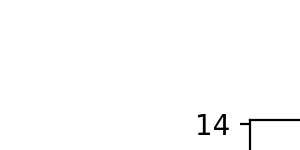

In [14]:
def mask_valid(line, ws):
    mask = (ws.day.unique()//86400 - date_index[0]).astype(int)
    mask = mask[(mask>0)&(mask<date_index.size)]  # super old xrootd??
    out = np.full_like(line, np.nan)
    out[mask] = line[mask]
    return out

window = '1w'
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(date_index_ts, mask_valid(size_cmssw[window], ws_cmssw)/1e15, label='CMSSW')
ax.plot(date_index_ts, mask_valid(size_classads[window], ws_classads)/1e15, label='ClassAds')
ax.plot(date_index_ts, mask_valid(size_xrootd[window], ws_xrootd)/1e15, label='XRootD')
ax.plot(date_index_ts, mask_valid(size_fwjr[window], ws_fwjr)/1e15, label='WMStats fwjr')
#ax.plot(date_index_ts, mask_valid(size_jobm[window], ws_jobm)/1e15, label='JobMonitoring')
ax.plot(date_index_ts, size_all[window]/1e15, label='Union', color='k', linewidth=2)


ax.legend(title='Data source')
ax.set_title('Working set comparison, *AOD data tiers')
ax.set_ylabel('Working set size [PB]')
ax.set_xlabel('Date (%s window)' % window)
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2021, 1, 1), None)

fig.savefig("plots/compare_workingset_aod_%s.pdf" % window)

In [15]:
print('FWJR Total: ',sum(size_fwjr[window]/1e15), ' PB')
print('CMSSW Total: ',sum(size_cmssw[window]/1e15), ' PB')

FWJR Total:  1323.3536084527575  PB
CMSSW Total:  1270.3598695356498  PB


In [16]:
ws_classads

,day,input_campaign,d_data_tier_id,working_set,working_set_blocks,data_tier
0,1.609459e+09,Run2016B-21Feb2020_ver2_UL2016_HIPM,31223,"[14065883, 14054868]","(22306308, 22306627, 22306657, 22306658, 22306...",MINIAOD
1,1.609459e+09,Run2018D-12Nov2019_UL2018,31223,"[14014937, 14013265, 14019258]","(21880109, 21880260, 21880387, 21880413, 21880...",MINIAOD
2,1.609718e+09,Run2017H-09Aug2019_UL2017_LowPU,31223,[14110726],"(22743734, 22750299, 22760618, 22767397, 22770...",MINIAOD
3,1.609805e+09,Run2017E-Nano25Oct2019,2056891,"[13964964, 13966301]","(21587297, 21587301, 21587304, 21596077, 21596...",NANOAOD
4,1.609891e+09,Phase2HLTTDRSummer20ReRECOMiniAOD,2066891,"[14157632, 14128429, 14125932, 14129590, 14128...","(22976170, 22976171, 22977158, 22978885, 22979...",GEN-SIM-DIGI-RAW-MINIAOD
...,...,...,...,...,...,...
48077,1.610928e+09,Run2018C-12Nov2019_UL2018,9,[13994685],"(21740124, 21741222, 21741528, 21743500, 21743...",AOD
48078,1.615248e+09,Run2018D-Nano1June2019_ver2,2056891,[13866590],"(20634791, 20634792, 20634793, 20641396, 20642...",NANOAOD
48079,1.624320e+09,Run2018A-v1,1,[13553947],"(18709768, 18711055, 18711795, 18713547, 18716...",RAW
48080,1.613866e+09,Run2018C-12Nov2019_UL2018_rsb,9,[14035505],"(22090555, 22094646, 22097718, 22098760, 22098...",AOD


In [17]:
ws_xrootd

,day,input_campaign,d_data_tier_id,client_domain,working_set_blocks,data_tier
0,1.609459e+09,Run2017F-31Mar2018,31223,lal.in2p3.fr,"(18627436, 18631847, 18631848)",MINIAOD
1,1.609459e+09,Run2018D-12Nov2019_UL2018,31223,None,(21988679),MINIAOD
2,1.609459e+09,SAM,21,None,"(17519371, 17785528)",AODSIM
3,1.609546e+09,Run2017C-31Mar2018,31223,t2.ucsd.edu,"(18626656, 18631308, 18632013, 18632147, 18632...",MINIAOD
4,1.609546e+09,Run2018A-17Sep2018,31223,physik.rwth-aachen.de,"(19544130, 19544330, 19562806, 19562834, 19562...",MINIAOD
...,...,...,...,...,...,...
205934,1.625962e+09,Run2018C-05May2019,31223,lnl.infn.it,"(20926647, 20926964, 20927649, 20928491, 20943...",MINIAOD
205935,1.625962e+09,RunIISummer20UL16MiniAODAPV,31224,cmsaf.mit.edu,"(23609947, 23609957)",MINIAODSIM
205936,1.626048e+09,HC,21,ifca.es,"(17787214, 17787215)",AODSIM
205937,1.626048e+09,RunIISummer16NanoAODv6,2056892,fnal.gov,"(21635195, 21635196, 21636793, 21636794, 21637...",NANOAODSIM
